In [212]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
from diffusers import UNet2DConditionModel, DDPMScheduler
import torch
from torch.optim import AdamW
from dataset import ADNIDataset
from torch.utils.data import DataLoader
from utils import sample_16_indices, indices_to_mask, save_tloss_csv, load_or_initialize_training, load_trained_model
import numpy as np
import matplotlib.pyplot as plt

In [213]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [214]:
batch_size = 10
num_train_timesteps = 128

In [215]:
model = UNet2DConditionModel(
    sample_size=128,
    in_channels=16, #16
    out_channels=8, #8 #initialise to maximum and compute loss only for indexed slices
    down_block_types=("DownBlock2D", "CrossAttnDownBlock2D"),
    mid_block_type=None,
    up_block_types=("CrossAttnUpBlock2D", "UpBlock2D"),
    # not sure about what the lower arguments do
    block_out_channels=(256, 512),
    layers_per_block=2, #default
    cross_attention_dim=256, # ~concat one-hot encodings of condition and target slices~ NO now instead just one 128 vector with labels 0,1,2
    attention_head_dim=8, #default
    norm_num_groups=32, #default
    use_linear_projection=True #DIFFERENT
)

In [351]:
print(model)

UNet2DConditionModel(
  (conv_in): Conv2d(16, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=256, out_features=1024, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 256, eps=1e-05, affine=True)
          (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=1024, out_features=256, bias=True)
          (norm2): GroupNorm(32, 256, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (co

In [216]:
model.to(device)

UNet2DConditionModel(
  (conv_in): Conv2d(16, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=256, out_features=1024, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 256, eps=1e-05, affine=True)
          (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=1024, out_features=256, bias=True)
          (norm2): GroupNorm(32, 256, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (co

In [217]:
noise_scheduler = DDPMScheduler(num_train_timesteps=num_train_timesteps)

In [218]:
load_trained_model(model, 'latest_ckpt.pth.tar')

Checkpoint loaded from epoch 139.


In [219]:
input_tensor = torch.zeros(batch_size, 16, 128, 128, device=device)

In [220]:
input_tensor[:, :8] = torch.randn(batch_size, 8, 128, 128, device=device)

In [240]:
num_slices=128

In [256]:
target = np.arange(0, 128, 16)

In [258]:
condition = []

In [259]:
target_encoding = np.zeros(num_slices)
target_encoding[target] = 1
condition_encoding = np.zeros(num_slices)
condition_encoding[condition] = 1
encoding = np.concatenate((target_encoding, condition_encoding))

In [ ]:
encoding = torch.tensor(encoding)
encoding = encoding.unsqueeze(0).to(device)
encoding = encoding.unsqueeze(1)
encoding = encoding.float()
encoding = encoding.repeat(batch_size,1,1)


In [261]:
encoding.shape

torch.Size([10, 1, 256])

In [ ]:
# for t in noise_scheduler.timesteps.flip(0):
for t in noise_scheduler.timesteps:
    print(f't is {t}')
    t_tensor = torch.tensor([t], device=device, dtype=torch.float32).repeat(batch_size)

    with torch.no_grad():
        predicted_noise = model(input_tensor, t_tensor, encoding).sample

    input_tensor[:, :8] = noise_scheduler.step(predicted_noise, t, input_tensor[:, :8]).prev_sample

t is 127
t is 126
t is 125
t is 124
t is 123
t is 122
t is 121
t is 120
t is 119
t is 118
t is 117
t is 116
t is 115
t is 114
t is 113
t is 112
t is 111
t is 110
t is 109
t is 108
t is 107
t is 106
t is 105
t is 104
t is 103
t is 102
t is 101
t is 100
t is 99
t is 98
t is 97
t is 96
t is 95
t is 94
t is 93
t is 92
t is 91
t is 90
t is 89
t is 88
t is 87
t is 86
t is 85
t is 84
t is 83
t is 82
t is 81
t is 80
t is 79
t is 78
t is 77
t is 76
t is 75
t is 74
t is 73
t is 72
t is 71
t is 70
t is 69
t is 68
t is 67
t is 66
t is 65
t is 64
t is 63
t is 62
t is 61
t is 60
t is 59
t is 58
t is 57
t is 56
t is 55
t is 54
t is 53
t is 52
t is 51
t is 50
t is 49
t is 48
t is 47
t is 46
t is 45
t is 44
t is 43
t is 42
t is 41
t is 40
t is 39
t is 38
t is 37
t is 36
t is 35
t is 34
t is 33
t is 32
t is 31
t is 30
t is 29
t is 28
t is 27
t is 26
t is 25
t is 24
t is 23
t is 22
t is 21
t is 20
t is 19
t is 18
t is 17
t is 16
t is 15
t is 14
t is 13
t is 12
t is 11
t is 10
t is 9
t is 8
t is 7
t is 6


In [263]:
predicted_noise.shape

torch.Size([10, 8, 128, 128])

In [264]:
input_tensor.shape

torch.Size([10, 16, 128, 128])

In [265]:
# fig, axes = plt.subplots(batch_size, 8, figsize=(15, 20))
# for b in range(batch_size):
#     for c in range(8):
#         ax = axes[b, c] if batch_size > 1 else axes[c]  # Handle single subplot case
#         ax.imshow(input_tensor[b, c].cpu(), cmap='gray')  # Assuming 0-indexed channel
#         ax.axis('off')  # Optional: turn off axis labels for better visualization
#         if b == 0:
#             ax.set_title(f'Slice {c}')  # Set channel title on the first row

# plt.tight_layout()
# plt.show()

/tmp/ipykernel_828740/695514611.py:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space for the colorbar


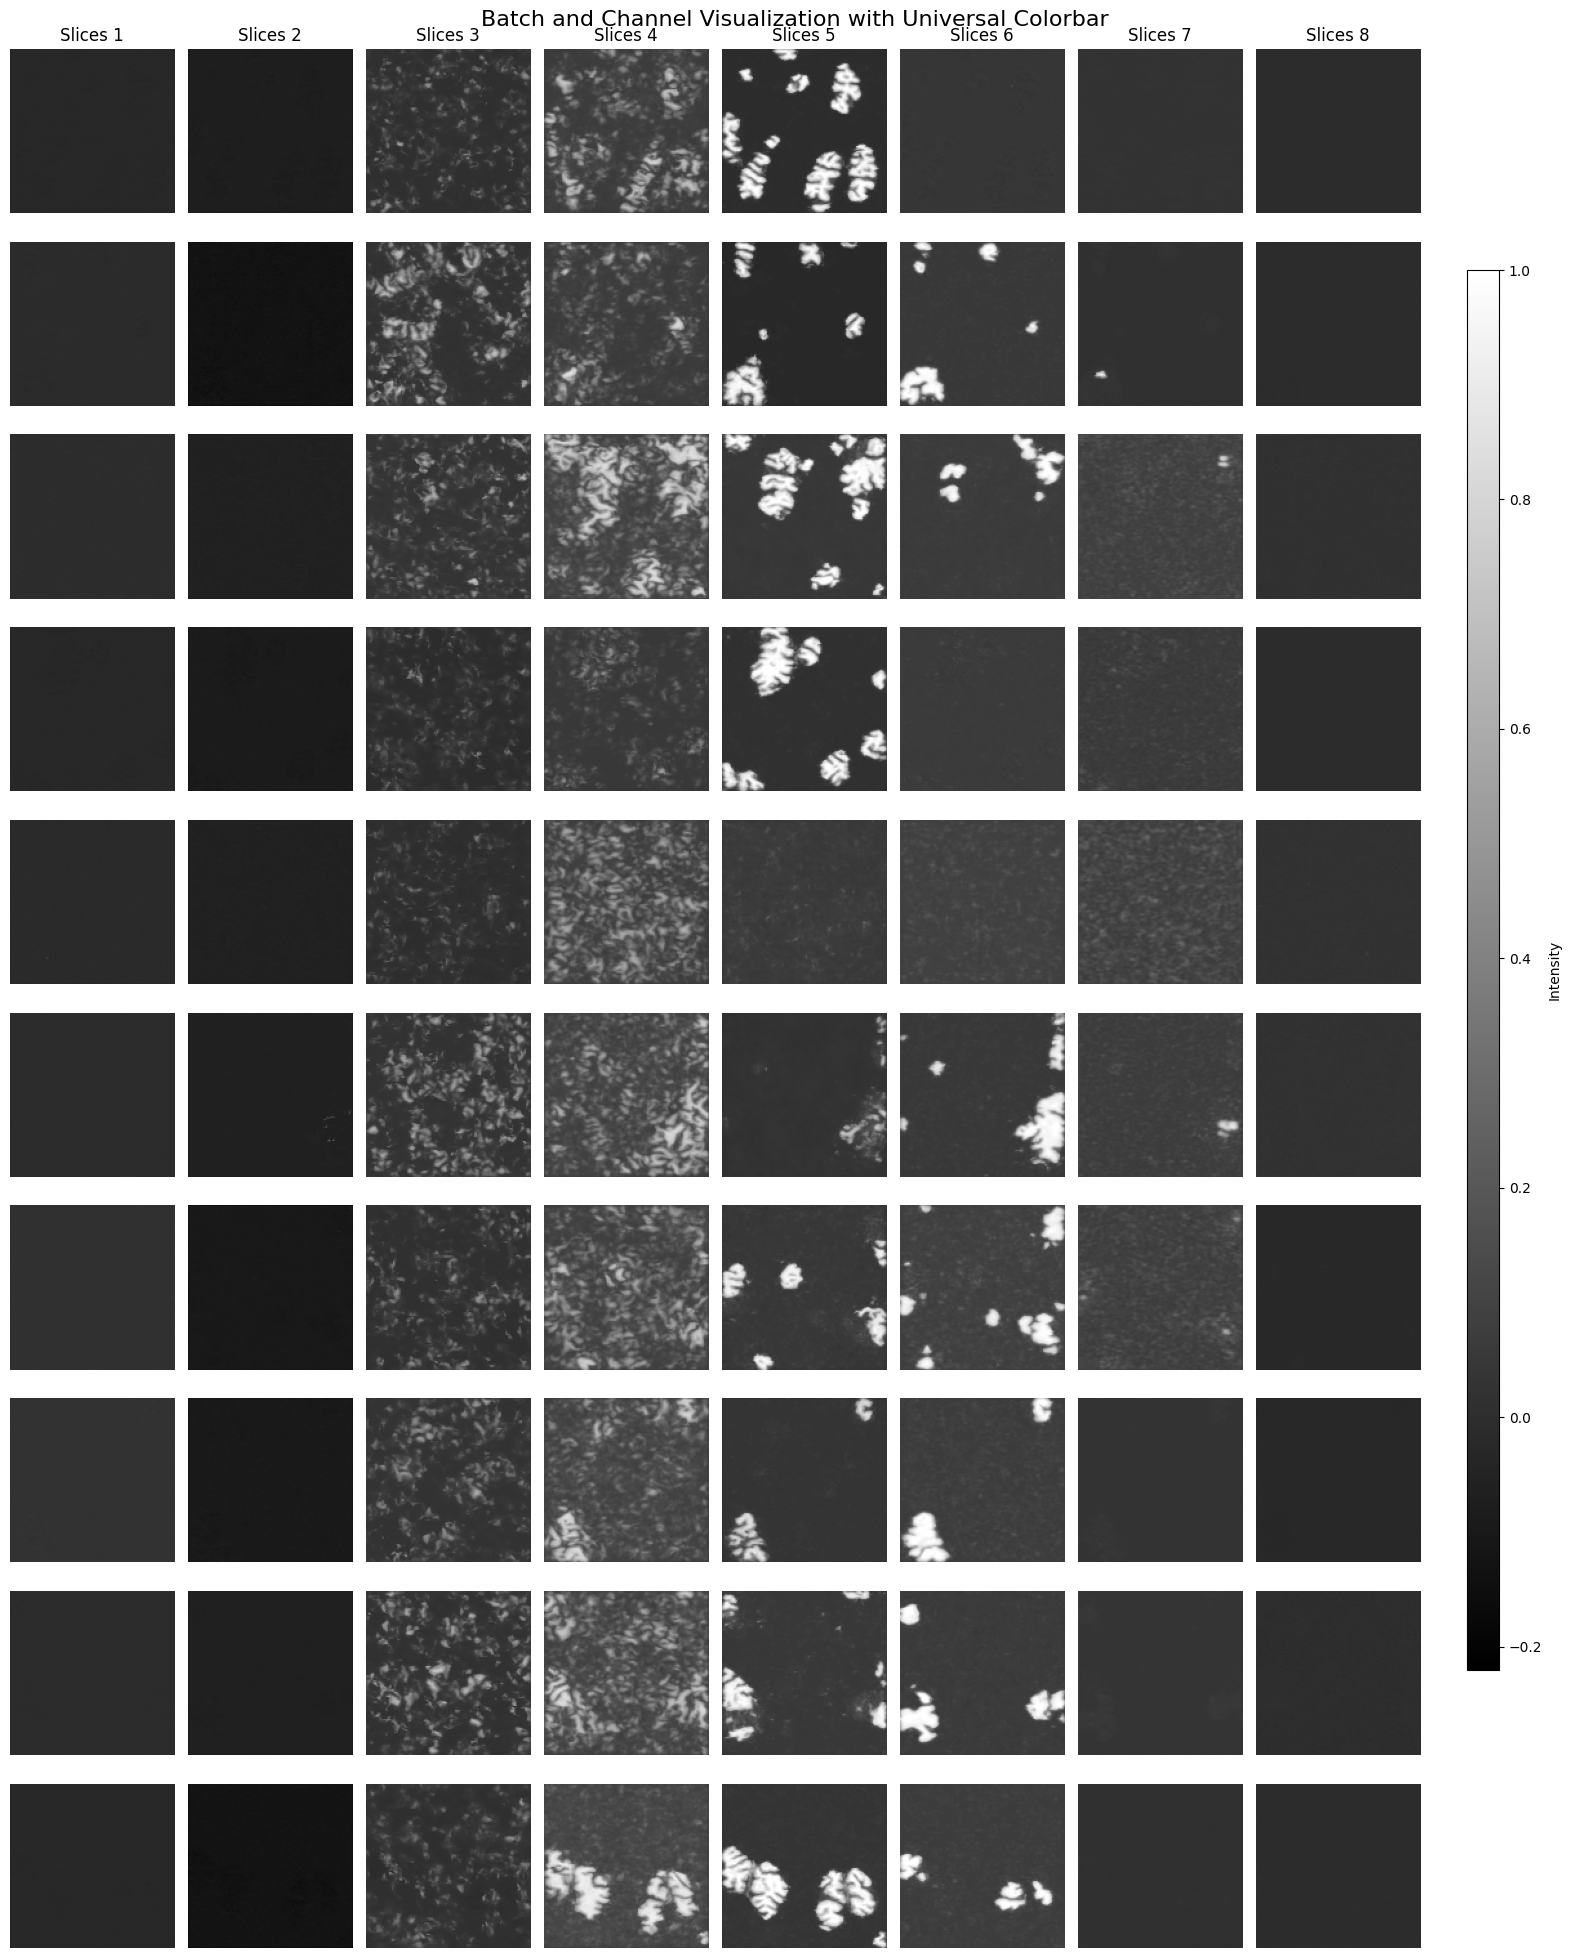

In [266]:
slices=8

# Create a grid of subplots with rows for batches and columns for channels
fig, axes = plt.subplots(batch_size, slices, figsize=(slices * 2, batch_size * 2))

# Determine the global min and max values for the color scale
vmin = input_tensor.min().item()
vmax = input_tensor.max().item()

# Loop through each batch and channel to plot
for b in range(batch_size):
    for c in range(slices):
        ax = axes[b, c] if batch_size > 1 else axes[c]  # Handle 1D subplot case
        im = ax.imshow(input_tensor[b, c].cpu(), cmap='gray', vmin=vmin, vmax=vmax)
        ax.axis('off')  # Optional: Remove axis labels for cleaner visualization
        if b == 0:
            ax.set_title(f'Slices {c+1}')  # Set channel title on the first row

# Add a universal colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax, label='Intensity')

# Add a global title or adjust layout
plt.suptitle('Batch and Channel Visualization with Universal Colorbar', fontsize=16)
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space for the colorbar
plt.show()

In [105]:
input_tensor[:, 10]

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:1')

In [106]:
encoding

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

For some reason, model is mainly only generating in middle slice of the output

* Need to check loss is doing what's expected
* Probably need more timesteps
* Maybe need a better way to encode the indices, and make it somehow order aware -- maybe use `nn.Embedding`
* Try to fully vectorise index sampling for during training

Maybe train a separate model just to predict the top 8 slices

Also check if this model works well if it is given conditioning slices

Zero out layers for condition might look like background

* Try training an unconditional model

Key
* Change sampling and encoding indices to be in the Dataset
* Specify num_workers = 4 in dataloader
* Change architecture to have more blocks: 3 Downblocks, 1 CrossAttnDownblock, 1 CrossAttnUpblock, 3 Upblocks; channels 64,128,256,512
* Change timesteps to 256

Extra
* Use `nn.Embedding` instead of one-hot encoding the indices


### Giving conditioning slices

In [267]:
data_dir = "/cim/data/adni_class_pred_1x1x1_v1/ADNI"
train_dataset = ADNIDataset(data_dir)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [269]:
one_batch = next(iter(train_dataloader))

In [319]:
input_tensor = torch.zeros(batch_size, 16, 128, 128, device=device)

In [320]:
prenoise = torch.randn(batch_size, 8, 128, 128, device=device)

In [321]:
input_tensor[:, :8] = prenoise

In [322]:
input_tensor[:, 8:] = one_batch[:, :8] # fill with top 8 layers from real MRI

In [323]:
input_tensor.shape

torch.Size([10, 16, 128, 128])

In [338]:
# slices=8

# # Create a grid of subplots with rows for batches and columns for channels
# fig, axes = plt.subplots(batch_size, slices, figsize=(slices * 2, batch_size * 2))

# # Determine the global min and max values for the color scale
# vmin = one_batch.min().item()
# vmax = one_batch.max().item()

# # Loop through each batch and channel to plot
# for b in range(batch_size):
#     for c in range(slices):
#         ax = axes[b, c] if batch_size > 1 else axes[c]  # Handle 1D subplot case
#         im = ax.imshow(one_batch[b, c].cpu(), cmap='gray', vmin=vmin, vmax=vmax)
#         ax.axis('off')  # Optional: Remove axis labels for cleaner visualization
#         if b == 0:
#             ax.set_title(f'Slices {c+1}')  # Set channel title on the first row

# # Add a universal colorbar
# cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
# fig.colorbar(im, cax=cbar_ax, label='Intensity')

# # Add a global title or adjust layout
# plt.suptitle('Batch and Channel Visualization with Universal Colorbar', fontsize=16)
# plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space for the colorbar
# plt.show()

In [345]:
target = np.arange(8,16)
condition = np.arange(8)

target_encoding = np.zeros(num_slices)
target_encoding[target] = 1
condition_encoding = np.zeros(num_slices)
condition_encoding[condition] = 1
encoding = np.concatenate((target_encoding, condition_encoding))

In [346]:
encoding = torch.tensor(encoding)
encoding = encoding.unsqueeze(0).to(device)
encoding = encoding.unsqueeze(1)
encoding = encoding.float()
encoding = encoding.repeat(batch_size,1,1)

In [347]:
encoding.shape

torch.Size([10, 1, 256])

In [341]:
enconding = encoding.float()
input_tensor = input_tensor.float()

In [ ]:
# for t in noise_scheduler.timesteps.flip(0):
for t in noise_scheduler.timesteps:
    print(f't is {t}')
    t_tensor = torch.tensor([t], device=device, dtype=torch.float32).repeat(batch_size)

    with torch.no_grad():
        # print(input_tensor.dtype, t_tensor.dtype, encoding.dtype)
        predicted_noise = model(input_tensor, t_tensor, encoding).sample

    input_tensor[:, :8] = noise_scheduler.step(predicted_noise, t, input_tensor[:, :8]).prev_sample

t is 127
torch.float32 torch.float32 torch.float32
t is 126
torch.float32 torch.float32 torch.float32
t is 125
torch.float32 torch.float32 torch.float32
t is 124
torch.float32 torch.float32 torch.float32
t is 123
torch.float32 torch.float32 torch.float32
t is 122
torch.float32 torch.float32 torch.float32
t is 121
torch.float32 torch.float32 torch.float32
t is 120
torch.float32 torch.float32 torch.float32
t is 119
torch.float32 torch.float32 torch.float32
t is 118
torch.float32 torch.float32 torch.float32
t is 117
torch.float32 torch.float32 torch.float32
t is 116
torch.float32 torch.float32 torch.float32
t is 115
torch.float32 torch.float32 torch.float32
t is 114
torch.float32 torch.float32 torch.float32
t is 113
torch.float32 torch.float32 torch.float32
t is 112
torch.float32 torch.float32 torch.float32
t is 111
torch.float32 torch.float32 torch.float32
t is 110
torch.float32 torch.float32 torch.float32
t is 109
torch.float32 torch.float32 torch.float32
t is 108
torch.float32 torch.fl

/tmp/ipykernel_828740/695514611.py:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space for the colorbar


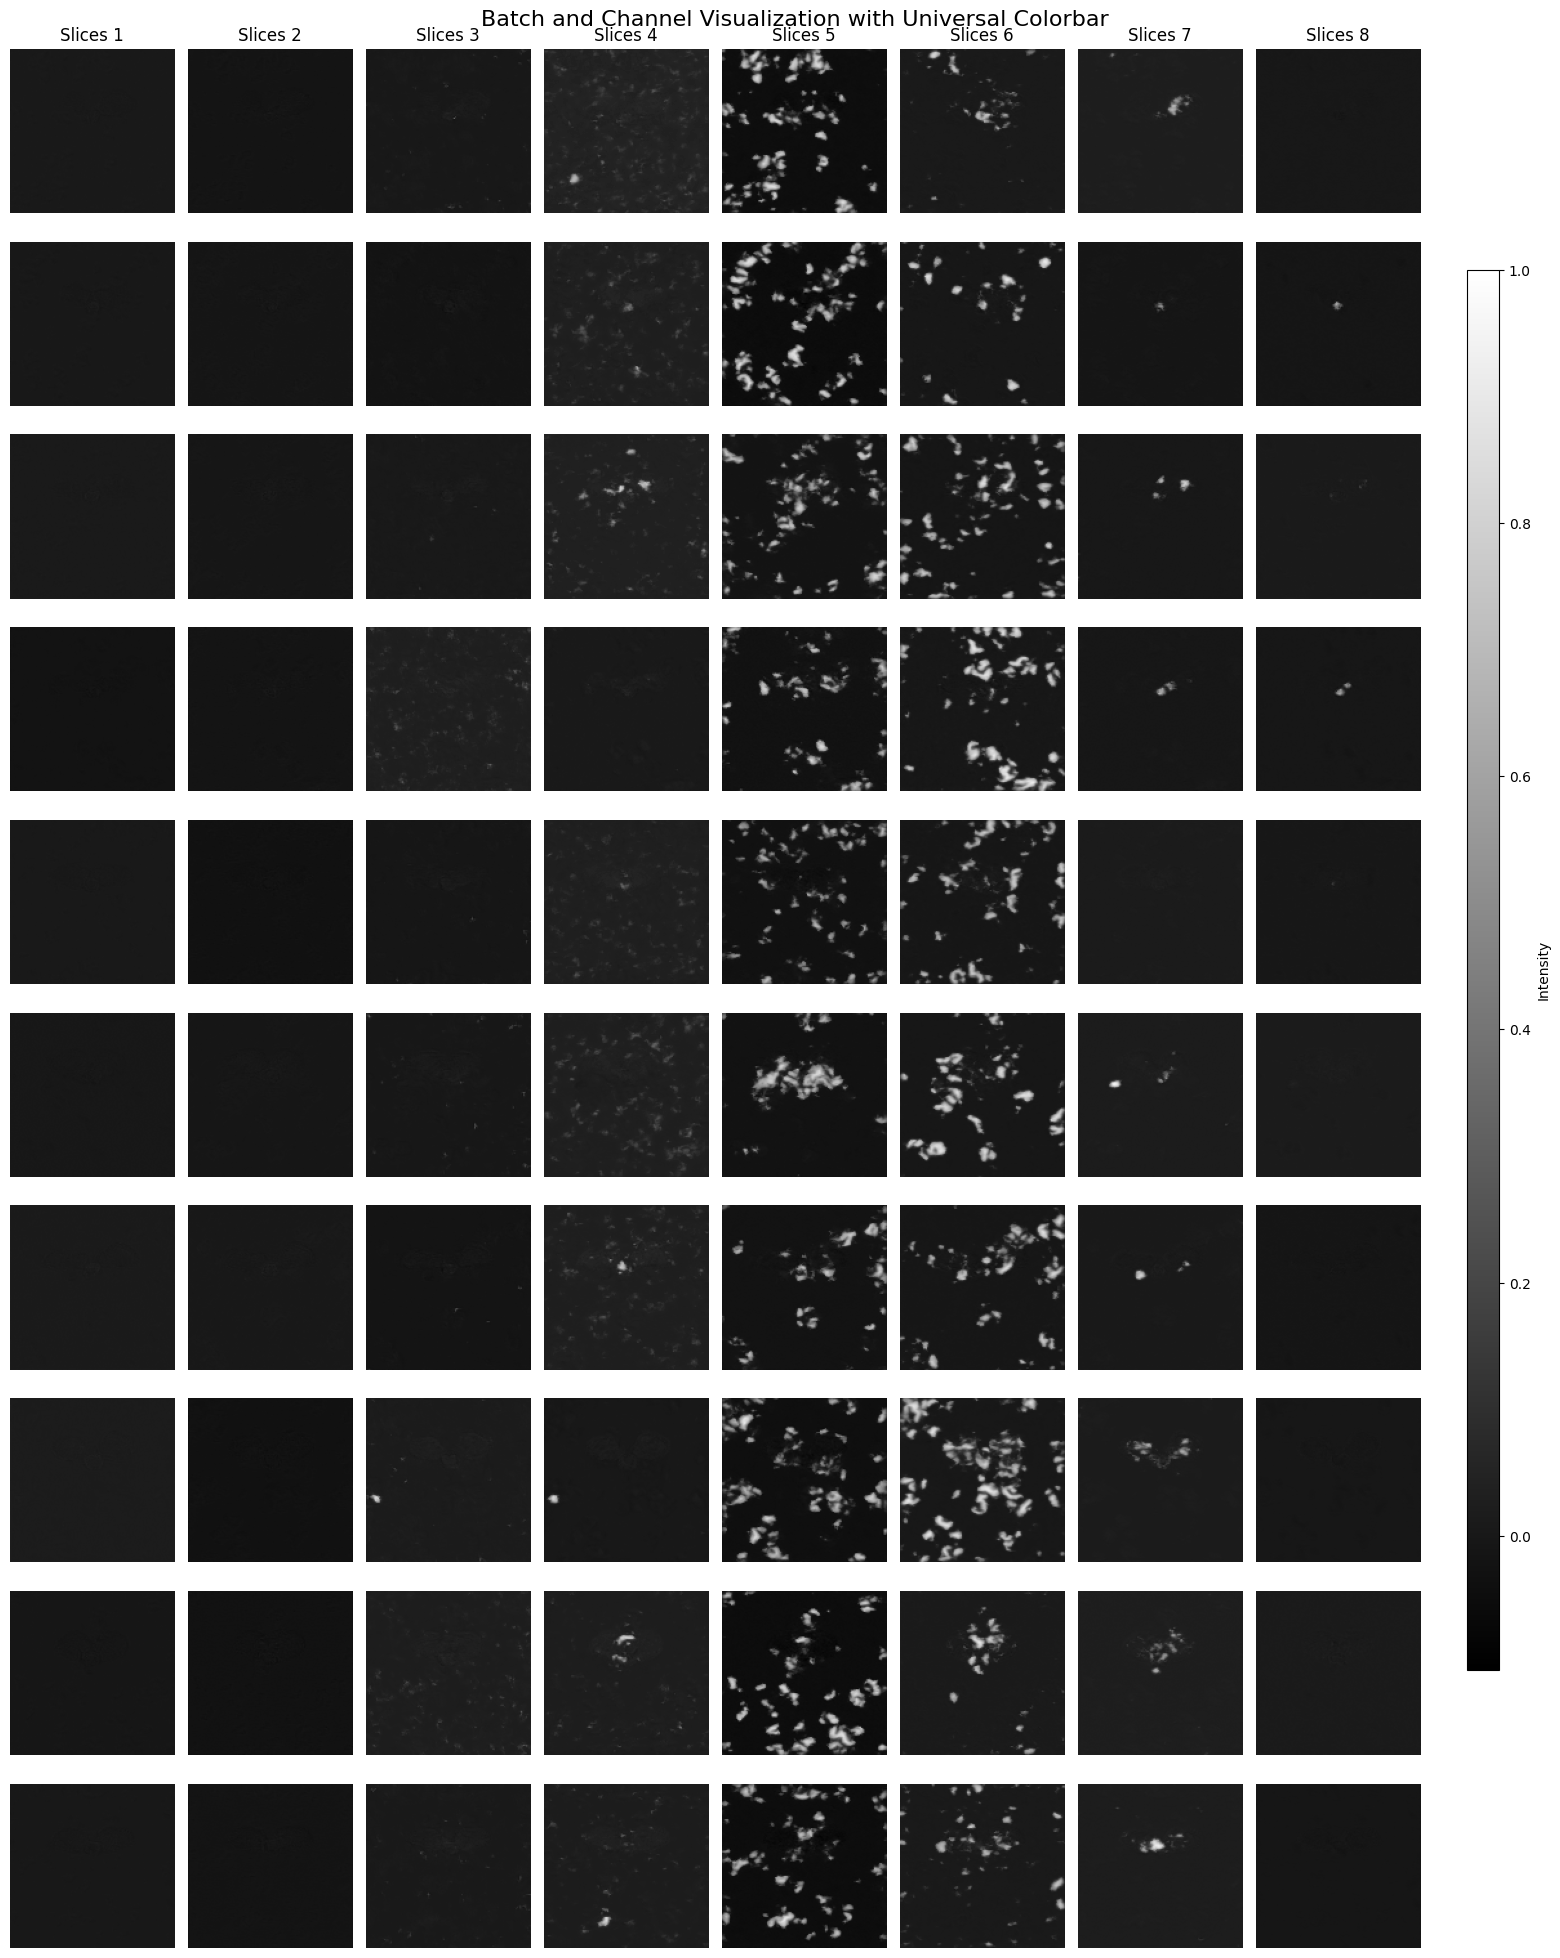

In [349]:
slices=8

# Create a grid of subplots with rows for batches and columns for channels
fig, axes = plt.subplots(batch_size, slices, figsize=(slices * 2, batch_size * 2))

# Determine the global min and max values for the color scale
vmin = input_tensor.min().item()
vmax = input_tensor.max().item()

# Loop through each batch and channel to plot
for b in range(batch_size):
    for c in range(slices):
        ax = axes[b, c] if batch_size > 1 else axes[c]  # Handle 1D subplot case
        im = ax.imshow(input_tensor[b, c].cpu(), cmap='gray', vmin=vmin, vmax=vmax)
        ax.axis('off')  # Optional: Remove axis labels for cleaner visualization
        if b == 0:
            ax.set_title(f'Slices {c+1}')  # Set channel title on the first row

# Add a universal colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax, label='Intensity')

# Add a global title or adjust layout
plt.suptitle('Batch and Channel Visualization with Universal Colorbar', fontsize=16)
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space for the colorbar
plt.show()